# エネルギーベースモデル

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
batch_size = 64

dataset = MNIST(
    root="data/",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

sample_x, _ = next(iter(dataloader))
w, h = sample_x.shape[2:]
image_size = w * h
print("batch shape:", sample_x.shape)
print("width:", w)
print("height:", h)
print("image size:", image_size)

batch shape: torch.Size([64, 1, 28, 28])
width: 28
height: 28
image size: 784


In [3]:
def draw(images, nrow=None, size=64):
    nrow = nrow or len(images)
    images = transforms.Resize(size, antialias=True)(images)
    img = torchvision.utils.make_grid(images, nrow)
    img = transforms.functional.to_pil_image(img)
    display(img)

def draw_hist(model, n_images=1, n_hist=10, size=64, **gen_kwargs):
    _, history = generate(model, n_images=n_images, **gen_kwargs)
    idx = torch.linspace(0, gen_kwargs.get("n_iter", 100)-1, n_hist).long()
    history = history[:,idx].view(-1, 1, h, w)
    draw(history, n_hist, size)

In [4]:
class EnergyModel(nn.Module):
    def __init__(self, image_size=image_size):
        super().__init__()
        self.image_size = image_size
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
def generate(
    model,
    n_images=batch_size,
    n_iter=100,
    step_size=1.,
    clamp=None,
    noise_std=0.1
):
    z = torch.randn(n_images, 1, h, w, device=device, requires_grad=True)
    history = []
    for _ in range(n_iter):
        img = F.sigmoid(z)
        history.append(img.view(-1, 1, h, w).cpu().clone())
        energy = model(img).mean()
        energy.backward()
        grad = z.grad
        grad = grad.clamp(-clamp, clamp) if clamp else grad
        z = z + step_size * grad
        z = z + torch.randn_like(z) * noise_std
        z = z.detach().requires_grad_()
    return img.detach(), torch.stack(history).transpose(0, 1)

In [6]:
def train(model, optim, n_epochs, alpha=0.1, n_draw_images=1, **gen_kwargs):
    model.train()
    for n in range(n_epochs):
        losses = []
        for (x_real, _) in tqdm(dataloader, desc=f'{n+1}epoch'):
            optim.zero_grad()
            x_real = x_real.to(device)
            x_fake, _ = generate(model, **gen_kwargs)

            out_real = model(x_real)
            out_fake = model(x_fake)
            loss_cd = out_fake.mean() - out_real.mean()
            loss_reg = alpha * (out_fake**2 + out_real**2).mean()
            loss = loss_cd + loss_reg
            loss.backward()
            losses.append(loss.item())
            optim.step()
        print(f"loss: {sum(losses)/len(losses)}")
        draw_hist(model, n_draw_images, **gen_kwargs)

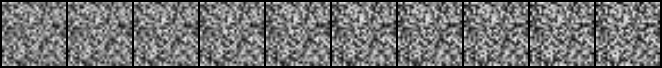

In [7]:
model = EnergyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
gen_kwargs = {'n_iter': 50, 'step_size': 0.5, 'noise_std': 0.1}
draw_hist(model)

1epoch: 100%|██████████| 156/156 [00:13<00:00, 11.15it/s]

loss: 1245.9703272743366


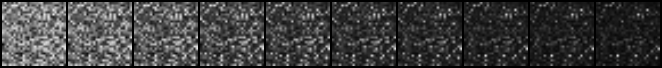

2epoch: 100%|██████████| 156/156 [00:13<00:00, 11.22it/s]

loss: 5940.497887244592


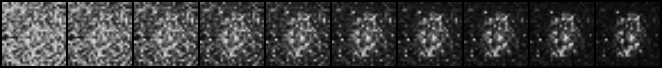

3epoch: 100%|██████████| 156/156 [00:14<00:00, 10.49it/s]

loss: 6208.05125388121


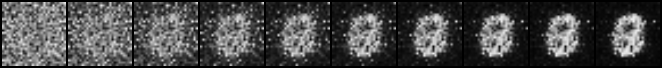

4epoch: 100%|██████████| 156/156 [00:14<00:00, 10.67it/s]


loss: 6395.824882311698


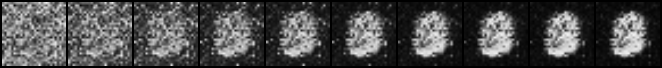

5epoch: 100%|██████████| 156/156 [00:13<00:00, 11.34it/s]


loss: 6430.49717986278


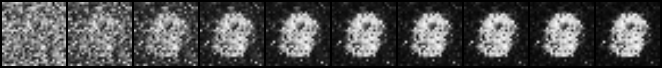

6epoch: 100%|██████████| 156/156 [00:13<00:00, 11.68it/s]

loss: 6446.382195888422


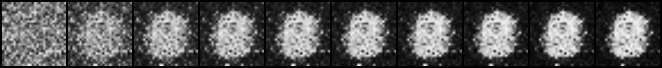

7epoch: 100%|██████████| 156/156 [00:13<00:00, 11.68it/s]


loss: 6521.247098482572


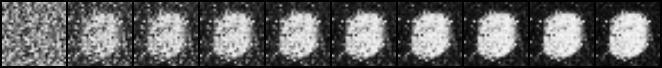

8epoch: 100%|██████████| 156/156 [00:13<00:00, 11.69it/s]

loss: 6721.4512125651045


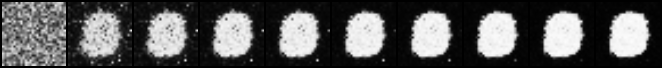

9epoch: 100%|██████████| 156/156 [00:12<00:00, 12.07it/s]

loss: 9864.772495367588


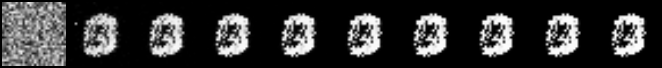

10epoch: 100%|██████████| 156/156 [00:12<00:00, 12.26it/s]

loss: 30657.00926482372


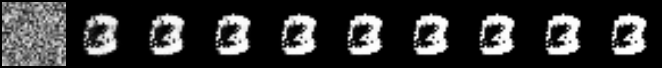

11epoch: 100%|██████████| 156/156 [00:12<00:00, 12.26it/s]

loss: 35246.07241586538


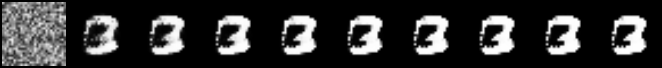

12epoch: 100%|██████████| 156/156 [00:12<00:00, 12.23it/s]

loss: 38808.04483423477


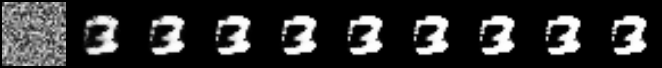

13epoch: 100%|██████████| 156/156 [00:12<00:00, 12.11it/s]

loss: 41390.7228503105


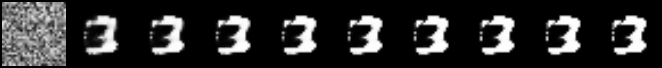

14epoch: 100%|██████████| 156/156 [00:12<00:00, 12.16it/s]

loss: 43337.97335111178


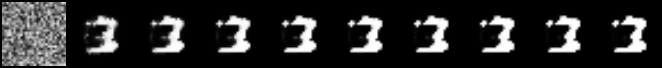

15epoch: 100%|██████████| 156/156 [00:12<00:00, 12.30it/s]


loss: 45043.79325045072


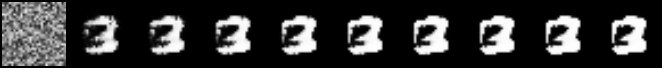

In [8]:
train(model, optimizer, 15, alpha=0.1, **gen_kwargs)

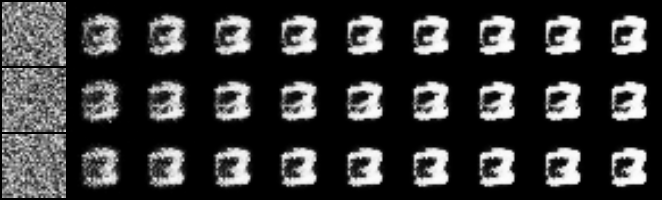

In [9]:
draw_hist(model, n_images=3, **gen_kwargs)

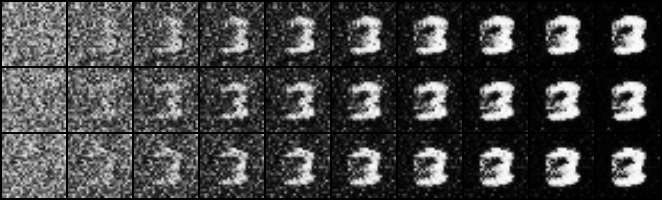

In [10]:
draw_hist(model, n_images=3, n_iter=50, step_size=0.1, noise_std=0.1, clamp=1)

In [11]:
x, _ = generate(model, n_images=1, **gen_kwargs)
model(x)

tensor([[782.0563]], grad_fn=<AddmmBackward0>)

## CNN

In [68]:
class EnergyModel(nn.Module):
    def __init__(self, image_size=image_size):
        super().__init__()
        self.image_size = image_size
        self.net = nn.Sequential(
            self.conv_block(1, 32, 4, 2, 1), # 14x14
            self.conv_block(32, 64, 4, 2, 1), # 7x7
            self.conv_block(64, 128, 3, 2, 0), # 3x3
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

device = torch.device('mps')

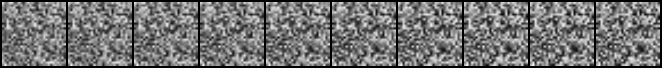

In [76]:
model = EnergyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
gen_kwargs = {'n_iter': 20, 'step_size': 0.5, 'clamp': 1.}
draw_hist(model)

1epoch: 100%|██████████| 156/156 [00:23<00:00,  6.73it/s]


loss: 0.3941855420352629


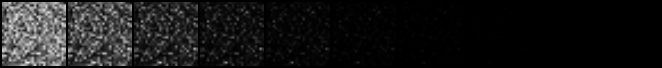

2epoch: 100%|██████████| 156/156 [00:23<00:00,  6.71it/s]


loss: 293.2185666072063


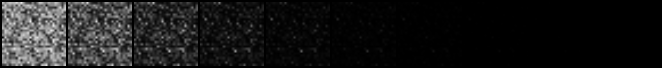

3epoch: 100%|██████████| 156/156 [00:23<00:00,  6.73it/s]


loss: 499.7799410697741


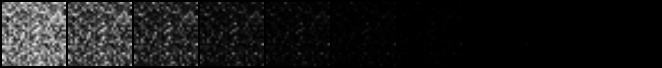

4epoch: 100%|██████████| 156/156 [00:23<00:00,  6.74it/s]


loss: 499.9997965494792


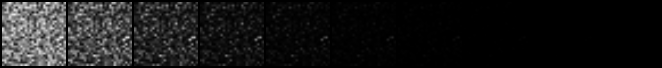

5epoch: 100%|██████████| 156/156 [00:23<00:00,  6.77it/s]


loss: 500.0000563401442


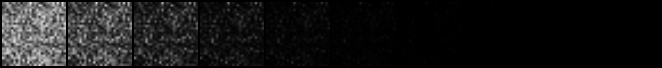

6epoch: 100%|██████████| 156/156 [00:23<00:00,  6.53it/s]


loss: 499.99998689309143


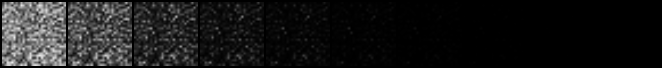

7epoch:  35%|███▌      | 55/156 [00:08<00:15,  6.49it/s]


KeyboardInterrupt: 

In [ ]:
train(model, optimizer, 20, **gen_kwargs)